# Training RetinaNet

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from importlib.util import find_spec
if find_spec("model") is None:
    import sys
    sys.path.append('..')

In [3]:
from fastai.vision.all import *
import torch.nn as nn

In [4]:
from data_loader.data_loaders import load_sample_coco_dls
from model.backbone.fpn import FPN, retinanet_fpn_resnet
from model.model import retina_resnet50
from model.loss import RetinaLoss

# Load the Data 

In [5]:
dls = load_sample_coco_dls(bs=16)

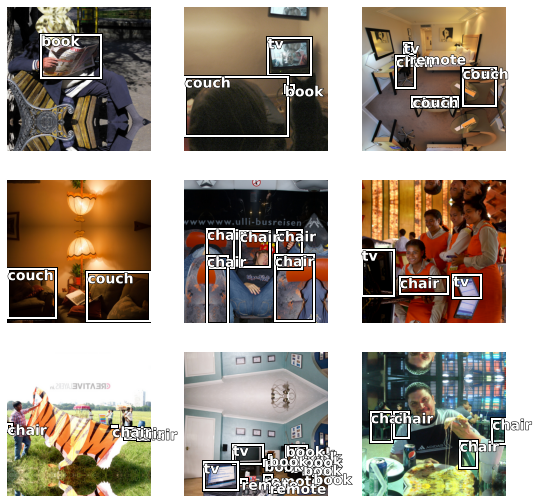

In [6]:
dls.show_batch()

# Build the Model

In [7]:
fpn_module = FPN(upsample_stages=[2048, 256], downsample_stages=[2048, 1024, 512])
fpn_module

FPN(
  (upsample_fpn3): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (upsample_fpn4): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (lat2): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
  (fpn2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (lat1): LateralUpsampleMerge(
    (lat_conv): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
  )
  (fpn1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (lat0): LateralUpsampleMerge(
    (lat_conv): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
  )
  (fpn0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU(inplace=True)
)

In [8]:
retina_fpn = retinanet_fpn_resnet()
retina_fpn

FPN(
  (upsample_fpn3): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (upsample_fpn4): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (lat2): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
  (fpn2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (lat1): LateralUpsampleMerge(
    (lat_conv): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
  )
  (fpn1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (lat0): LateralUpsampleMerge(
    (lat_conv): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
  )
  (fpn0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU(inplace=True)
)

## RetinaNet50

In [6]:
num_classes = 6

In [7]:
model = retina_resnet50(num_classes=num_classes)

# Focal Loss

## Allow Low Quality Matches

In [11]:
criterion = RetinaLoss(num_classes=num_classes, allow_low_quality_matches=True)

Freeze everything except encoder (base arch).

In [10]:
def _retinanet_split(m): return L(m.base, nn.Sequential(m.backbone, m.head)).map(params)

In [13]:
learn = Learner(dls, model, loss_func=criterion, splitter=_retinanet_split)

In [14]:
learn.freeze()

In [ ]:
learn.fit_one_cycle(10, slice(1e-5, 1e-4))

epoch,train_loss,valid_loss,time
0,0.014028,0.013984,10:48
1,0.013460,0.011781,10:49


## Don't Allow Low Quality Matches

In [8]:
criterion = RetinaLoss(num_classes=num_classes)

In [11]:
learn = Learner(dls, model, loss_func=criterion, splitter=_retinanet_split)

In [12]:
learn.freeze()

In [ ]:
learn.fit_one_cycle(10, slice(1e-5, 1e-4))

epoch,train_loss,valid_loss,time
0,0.000000,0.000000,10:21
1,0.000000,0.000000,10:18
